In [52]:
# version 2.0
# 1.fix a bug, that requires to create a folder: os.mkdir("output")
# 2.save data to google drive and use DVC to extract the inputs

- number of cores, set this number according to your computer

In [1]:
from stock_helper import *
from stats import *
from product_info import *
from imp import reload  
import stock_helper
import stats
reload(stock_helper)
reload(stats)


<module 'stats' from '/Users/junsu/Dropbox/workspace/stock_week5/src/w3/src/stats.py'>

In [2]:
import warnings
 
warnings.filterwarnings('ignore')

- sample product, you can change to your specific product symbol

In [3]:
product_list = ["600519", "000858", "000568", "600809", "002304"]
product = product_list[0]

In [4]:
import dask
from dask import compute, delayed

In [5]:
#CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM = 11
## 16

- get the list of this form

# Parameters

In [6]:
period = 4096

# Paths

In [7]:
HEAD_PATH = './'
DATA_PATH = HEAD_PATH + "data/stocks/"
SAVE_PATH = HEAD_PATH + "ckpt/"
TEMP_PATH = SAVE_PATH + "tmp pkl/"
OUTPUT_PATH = HEAD_PATH + 'output'

In [8]:
import os
for product in product_list:
    os.makedirs(TEMP_PATH + product, exist_ok=True)

# Data Loading & Test

In [9]:
all_years = list(map(lambda x: x,os.listdir(DATA_PATH + product_list[0])))
n_years = len(all_years)
n_years
## 11

11

- number of years

In [10]:
all_years


['2015.pkl',
 '2014.pkl',
 '2016.pkl',
 '2017.pkl',
 '2013.pkl',
 '2012.pkl',
 '2011.pkl',
 '2020.pkl',
 '2021.pkl',
 '2019.pkl',
 '2018.pkl']

- some days may have error because of rolling contracts

- we randomly choose a day

- plot all the data

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

data = load(DATA_PATH + product_list[0] + "/"+all_years[0])

In [60]:
data = data.sort_values(['date.time'], ascending=[1]).reset_index(drop=True)

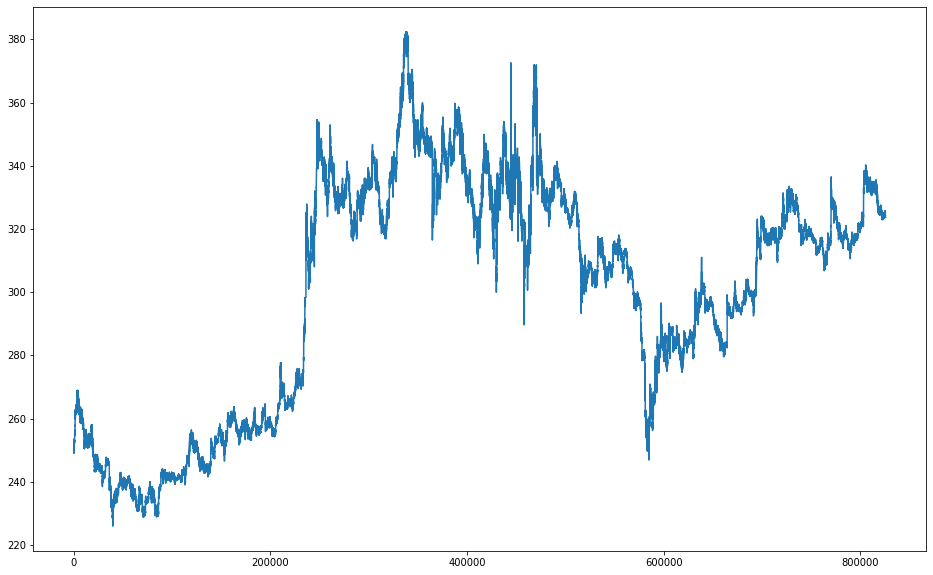

In [62]:
plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values);

- Welcome to Quantitative and High Frequency Trading Training Program


- number of usable points

In [12]:
#period = 4096

- the first signal is the buy/sell imbalance signal


- create directory for all signals

- create directory for the product

In [13]:
'''
import os
for product in product_list:
    os.makedirs(SAVE_PATH + "tmp_pkl/" + product, exist_ok=True)
'''    

'\nimport os\nfor product in product_list:\n    os.makedirs(SAVE_PATH + "tmp_pkl/" + product, exist_ok=True)\n'

- create directory for the signal

- now let's check the signal


- it's the buy/sell imbalance of one tick

- zero_divide is zero when denominator is zero
- we can see the definition of zero_divide in helper.py


- returns 0 if the numerator or denominator is 0

# Factor - nr / atr

## Define Factor

### atr

In [63]:
def zero_divide(x, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = np.divide(x,y)
    if hasattr(y, "__len__"):
        res[y == 0] = 0
    elif y == 0:
        res = 0
        
    return res

In [64]:
## calculate the range of price
## there may be several periods of range here, divided by wpr
## look-back periods are in period_list
## typically, 1024, 2048, 4096
## for index futures, 1024 may be useful
## for black commodities, 2048 may be useful
## for other commodities, 4096 may be useful
## here we use 4096
def get_atr(file, product, period_list):
    data = load(file)
    for period in period_list:
        S = (data["max."+str(period)]-data["min."+str(period)])/data["wpr"]
        save(S, TEMP_PATH+product+"/atr."+str(period)+"/" + file[-8:])

### nr

In [65]:
## calculate exponential moving avergae
## may different from python's ewm
## warning: adjust is NOT the adjust of ewm
## the adjust of ewm is ALWAYS False
## look-back period is halflife in ewma
## halflife is the period of alpha decay to half
## this is only one method to calculate ewma, there are others, suchas (n-1)/(n+1) and 2/(n+1)
## if adjust=false, the first (period-1) values may be too large
## so we use adjust=true to adjust it, it's divided by aa
## and the first (period-1) values are normal in value
def ewma(x, halflife, init=0, adjust=False):
    init_s = pd.Series(data=init)
    s = init_s.append(x)
    if adjust:
        xx = range(len(x))
        lamb=1 - 0.5**(1 / halflife)
        aa=1-np.power(1-lamb, xx)*(1-lamb)
        bb=s.ewm(halflife=halflife, adjust=False).mean().iloc[1:]
        return bb/aa
    else:
        return s.ewm(halflife=halflife, adjust=False).mean().iloc[1:]

In [66]:
## to calculate the normalized return
## class of factor
## 3 parts: factor_name, params, formula
## 2^[10:13]=(1024,2048,3096)
## the idea is ret/|ret|
## then over a period, we divided by period in numerator and denominator
## (ret/period)/(|ret|/period)
## then we use ewma(ret)/ewma(|ret|) instead of mean return
## because calculate ewma is faster and easier
## but the first period items may not be correct for ewma
## so we use adjust=True
## but since there is avdivision, actually we don't need to use adjust=True
## they would be the same with or withour adjust=True
from collections import OrderedDict
class foctor_nr_period(factor_template):
    factor_name = "nr.period"
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    def formula(self, data, period):
        return zero_divide(ewma(data["ret"], period, adjust=True), ewma(data["ret"].abs(), period, adjust=True)).values

## Factor Generation

In [67]:
## procedure to calculate a signal
## first use a variable to define the class object
x3 = foctor_nr_period()
#SAVE_PATH = "e:/intern"
## then create directories to save the result
for product in product_list:
    create_signal_path(x3, product, SAVE_PATH);
    
# e:/intern/tmp pkl/600519/nr.4096
# e:/intern/tmp pkl/000858/nr.4096
# e:/intern/tmp pkl/000568/nr.4096
# e:/intern/tmp pkl/600809/nr.4096
# e:/intern/tmp pkl/002304/nr.4096

./ckpt//tmp pkl/600519/nr.4096
./ckpt//tmp pkl/000858/nr.4096
./ckpt//tmp pkl/000568/nr.4096
./ckpt//tmp pkl/600809/nr.4096
./ckpt//tmp pkl/002304/nr.4096


In [68]:
for product in product_list:
    for period in [1024,2048,4096]:
        os.makedirs(TEMP_PATH + product+"/atr."+str(period), exist_ok=True)

In [69]:
file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product))) ## files of each day

In [70]:
%%time 
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product))) ## files of each day
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3, product=product, HEAD_PATH=SAVE_PATH, n=8)
;
# Wall time: 2min 58s


CPU times: user 297 ms, sys: 309 ms, total: 606 ms
Wall time: 38.1 s


''

- we can check the result

- we can see that they are the same
- so the signal calculation process is correct


- now calcualte all the value of this signal

## Assess signal stationary

In [71]:
import statsmodels.tsa.stattools as ts
import math

In [72]:
signal_name = "nr.4096"
period = 4096
for product in product_list:
    all_signal = np.array([])
    all_dates = list(map(lambda x: x,os.listdir(DATA_PATH + product)))
    n_days = len(all_dates)
    for file in np.array(all_dates):
        data = load(DATA_PATH+product+"/"+file)
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        all_signal = np.concatenate((all_signal, S), axis=0)
    sample_signal = all_signal[np.arange(1,len(all_signal)+1)% period==0]
    result = ts.adfuller(sample_signal, maxlag=int(pow(len(sample_signal)-1,(1/3))), regression='ct', autolag=None)
    print(product, "adf", result)
    result = ts.kpss(sample_signal, regression='c', lags=int(3*math.sqrt(len(sample_signal))/13))
    print(product, "kpss", result)
    
# 600519 adf (-10.798530575015935, 5.436961966222466e-17, 12, 1963, {'1%': -3.9633892647633338, '5%': -3.412728927627907, '10%': -3.128368189148487})
# 600519 kpss (0.6132498630689999, 0.02143183063009092, 10, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
# 000858 adf (-11.822563758002369, 7.517782979416387e-19, 13, 2391, {'1%': -3.9625613061699765, '5%': -3.412327803056771, '10%': -3.128132076740814})
# 000858 kpss (0.8683144207314412, 0.01, 11, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
# 000568 adf (-11.67248866086197, 1.3495337146461561e-18, 12, 1986, {'1%': -3.9633356838935874, '5%': -3.4127029714768047, '10%': -3.128352911383938})
# 000568 kpss (1.0088298782578713, 0.01, 10, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
# 600809 adf (-10.76365366816175, 6.360776409607664e-17, 11, 1594, {'1%': -3.9644607071383136, '5%': -3.4132478962457613, '10%': -3.1286736331034946})
# 600809 kpss (1.1927783835667125, 0.01, 9, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
# 002304 adf (-10.589567406815283, 1.4059347334364424e-16, 12, 1754, {'1%': -3.963940667692018, '5%': -3.4129960241743813, '10%': -3.1285253962467308})
# 002304 kpss (0.32206437567032065, 0.1, 9, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


600519 adf (-10.77027376986097, 6.173781938205922e-17, 12, 1963, {'1%': -3.9633892647633338, '5%': -3.412728927627907, '10%': -3.128368189148487})
600519 kpss (0.09892166830210107, 0.1, 10, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
000858 adf (-12.072363564289171, 2.940244191372255e-19, 13, 2391, {'1%': -3.9625613061699765, '5%': -3.412327803056771, '10%': -3.128132076740814})
000858 kpss (0.1990278952882251, 0.1, 11, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
000568 adf (-11.522826828274866, 2.455782902851271e-18, 12, 1986, {'1%': -3.9633356838935874, '5%': -3.4127029714768047, '10%': -3.128352911383938})
000568 kpss (0.16943842672412063, 0.1, 10, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
600809 adf (-10.41815818384293, 3.117529659673225e-16, 11, 1594, {'1%': -3.9644607071383136, '5%': -3.4132478962457613, '10%': -3.1286736331034946})
600809 kpss (0.20731268535090921, 0.1, 9, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
002304 ad

- for adf, if p-valus(the second one) is small, then it's stationary;
- for kpss, if p-value is large, then it's stationary;
- so for trade.imb.4096, all of them are stationary
- now we calcualte another signal which measures the range ranther than direciton

In [73]:
def add_min_max(file, period_list):
    data = load(file)
    data = data.reset_index(drop=True)
    for period in period_list:
        data["min."+str(period)] = data["wpr"].rolling(period).min()
        data.loc[:period-1, ("min."+str(period))] = data["wpr"][0]
        
        data["max."+str(period)] = data["wpr"].rolling(period).max()
        data.loc[:period-1, ("max."+str(period))] = data["wpr"][0]
    save(data, file)

In [74]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, all_dates))
    parLapply(CORE_NUM, file_list, add_min_max, period_list=[4096])

#Wall time: 1min 18s

CPU times: user 139 ms, sys: 322 ms, total: 461 ms
Wall time: 46.9 s


In [75]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, get_atr, product=product,period_list=np.power(2, range(12,13))) 
    
# Wall time: 1min 36s

CPU times: user 146 ms, sys: 293 ms, total: 439 ms
Wall time: 17 s


- It measures how many bid/ask spreads of range in the previous period 
- In this case, we can measure volatility of each product in similar criteron
- because slippage is the largest cost for intraday trading

- Then we can modify our backtest program to include a trend signal and a range signal

In [77]:
all_product_signal = dict([])
for product in product_list:
    all_signal = np.array([])
    all_dates = list(map(lambda x: x,sorted(os.listdir(DATA_PATH + product)))) # added sort function
    n_days = len(all_dates)
    for file in np.array(all_dates):
        data = load(DATA_PATH+product+"/"+file)
        input_file = SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file
        print(input_file)
        S = load(input_file)
        all_signal = np.concatenate((all_signal, S), axis=0)
    all_product_signal[product] = all_signal

./ckpt//tmp pkl/600519/nr.4096/2011.pkl
./ckpt//tmp pkl/600519/nr.4096/2012.pkl
./ckpt//tmp pkl/600519/nr.4096/2013.pkl
./ckpt//tmp pkl/600519/nr.4096/2014.pkl
./ckpt//tmp pkl/600519/nr.4096/2015.pkl
./ckpt//tmp pkl/600519/nr.4096/2016.pkl
./ckpt//tmp pkl/600519/nr.4096/2017.pkl
./ckpt//tmp pkl/600519/nr.4096/2018.pkl
./ckpt//tmp pkl/600519/nr.4096/2019.pkl
./ckpt//tmp pkl/600519/nr.4096/2020.pkl
./ckpt//tmp pkl/600519/nr.4096/2021.pkl
./ckpt//tmp pkl/000858/nr.4096/2011.pkl
./ckpt//tmp pkl/000858/nr.4096/2012.pkl
./ckpt//tmp pkl/000858/nr.4096/2013.pkl
./ckpt//tmp pkl/000858/nr.4096/2014.pkl
./ckpt//tmp pkl/000858/nr.4096/2015.pkl
./ckpt//tmp pkl/000858/nr.4096/2016.pkl
./ckpt//tmp pkl/000858/nr.4096/2017.pkl
./ckpt//tmp pkl/000858/nr.4096/2018.pkl
./ckpt//tmp pkl/000858/nr.4096/2019.pkl
./ckpt//tmp pkl/000858/nr.4096/2020.pkl
./ckpt//tmp pkl/000858/nr.4096/2021.pkl
./ckpt//tmp pkl/000568/nr.4096/2011.pkl
./ckpt//tmp pkl/000568/nr.4096/2012.pkl
./ckpt//tmp pkl/000568/nr.4096/2013.pkl


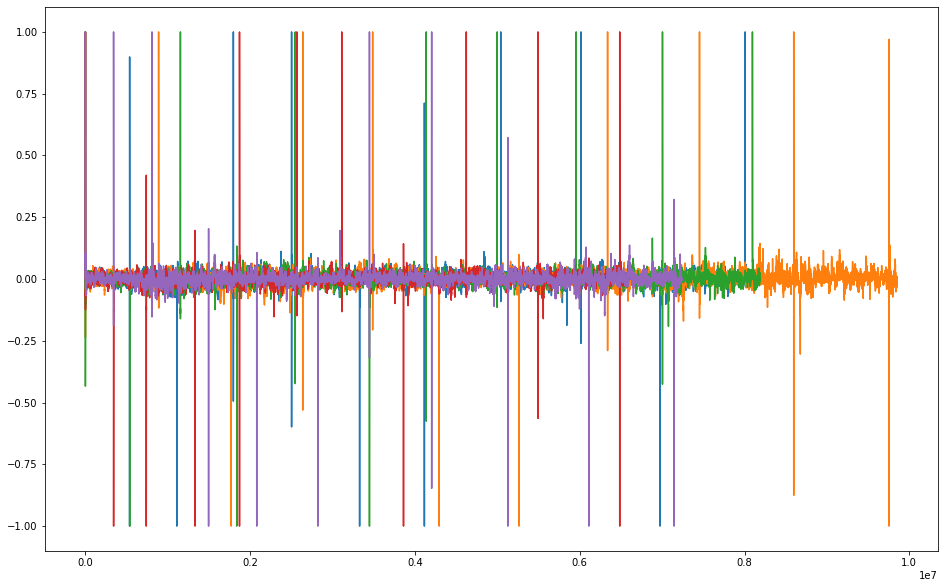

In [78]:
for product in product_list:
    plt.figure(1, figsize=(16, 10))
    plt.plot(all_product_signal[product]);

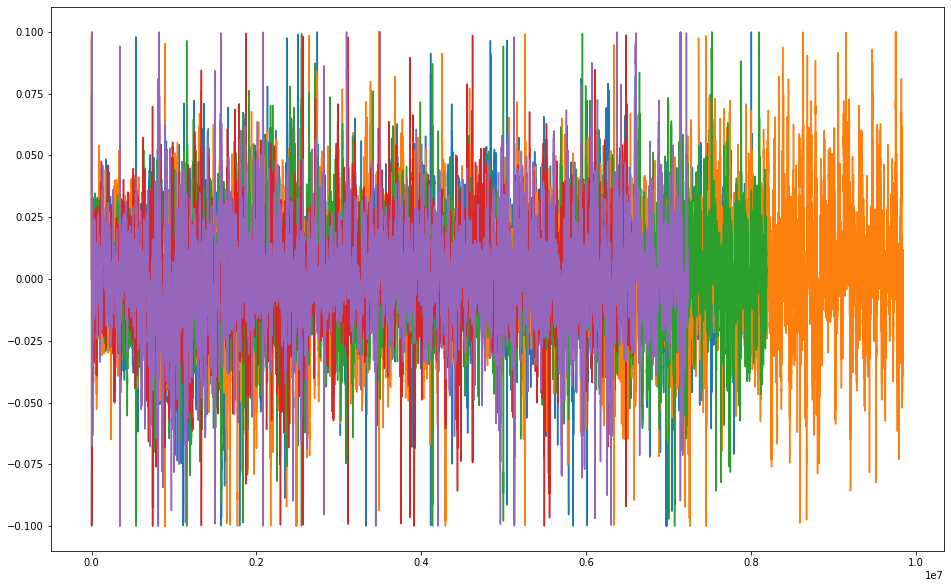

In [79]:
for product in product_list:
    vanish_thre(all_product_signal[product],0.1)
    plt.figure(1, figsize=(16, 10))
    plt.plot(all_product_signal[product]);

In [80]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.04, 0.1, 0.003)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))


## Strategy based on nr & atr

In [81]:
from collections import OrderedDict
def get_signal_pnl(file, product, signal_name, thre_mat, reverse=1,  buy_tranct=1.5e-4, sell_tranct=11.5e-4,
                   max_spread=0.011,
                   HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH, atr_filter=0):
    ## load data
    data = load(DATA_PATH+product+"/"+file)
    S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
    pred = S*reverse
    atr = load(SAVE_PATH+"/tmp pkl/"+product+"/"+"atr.4096"+"/"+file)
    #n_bar = len(data)
    
    ## load signal
    
    ## we don't know the signal is positive correlated or negative correlated  
    #n_thre = len(thre_mat)
    date = np.array([x[0:10] for x in data["date.time"]])
    next_date = np.append(date[1:],'1')
    end_day = date!=next_date
    count = 0;
    n_day = sum(end_day)
    n_thre = np.shape(thre_mat)[0]
    all_pnl = np.zeros((n_day, n_thre))
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)

    cur_spread = data["ask1"]-data["bid1"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos = pd.Series(data=0, index=data.index)
        notional_position_pos[position_pos==1] = 1
        notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos[(notional_position_pos==1)] = 1/data["next.ask"][(notional_position_pos==1)]
        notional_position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg = pd.Series(data=0, index=data.index)
        notional_position_neg[position_neg==-1] = -1
        notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg[(notional_position_neg==-1)] = -1/data["next.bid"][(notional_position_neg==-1)]
        notional_position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position = notional_position_pos+notional_position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-2:] = 0
        notional_position.iloc[0] = 0
        notional_position.iloc[-2:] = 0
        #change_pos = position - position.shift(1)
        #notional_change_pos = notional_position-notional_position.shift(1)
        change_pos = notional_position-notional_position.shift(1)
        change_pos.iloc[0] = 0
        #notional_change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        change_base[change_buy] = data["next.ask"][change_buy]*(1+buy_tranct)*data["adjust"]
        change_base[change_sell] = data["next.bid"][change_sell]*(1-sell_tranct)*data["adjust"]
        raw_pnl = -(change_base*change_pos).cumsum()+notional_position*data["wpr"]
        final_pnl = -sum(change_base*change_pos) ## total pnl, there is a negative sign, because selling get money and buying pay money
        turnover = sum(change_base*abs(change_pos))
        num = sum((position!=0) & (change_pos!=0)) ## number of trades
        hld_period = sum(position!=0)   ## holding period
        daily_pnl = raw_pnl[end_day].reset_index(drop=True)
        pnl = np.append(daily_pnl[0], np.diff(daily_pnl))
        all_pnl[:,thre[0]] = pnl
        if (num==0):
            result.loc[thre[0], ("num","avg.ret","ret")] = (0,0,0)
        else:
            result.loc[thre[0],("num", "avg.ret", "ret", )] = (num, final_pnl/num, final_pnl)
    return OrderedDict([("all.pnl", all_pnl), ("result", result), ("date", date[end_day])])

- First we want to know the range of signal

## Load Factor Signals

In [84]:
signal_name = "nr.4096"
all_product_signal = dict([])
for product in product_list:
    all_dates = list(map(lambda x: x, sorted(os.listdir(DATA_PATH + product))))
    n_days = len(all_dates)
    all_signal = np.array([])
    for file in np.array(all_dates):
        input_file = DATA_PATH+product+"/"+file
        print(input_file)
        data = load(input_file)
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        S[abs(S)>0.1] = 0
        all_signal = np.concatenate((all_signal, S), axis=0)
    all_product_signal[product] = all_signal

./data/stocks/600519/2011.pkl
./data/stocks/600519/2012.pkl
./data/stocks/600519/2013.pkl
./data/stocks/600519/2014.pkl
./data/stocks/600519/2015.pkl
./data/stocks/600519/2016.pkl
./data/stocks/600519/2017.pkl
./data/stocks/600519/2018.pkl
./data/stocks/600519/2019.pkl
./data/stocks/600519/2020.pkl
./data/stocks/600519/2021.pkl
./data/stocks/000858/2011.pkl
./data/stocks/000858/2012.pkl
./data/stocks/000858/2013.pkl
./data/stocks/000858/2014.pkl
./data/stocks/000858/2015.pkl
./data/stocks/000858/2016.pkl
./data/stocks/000858/2017.pkl
./data/stocks/000858/2018.pkl
./data/stocks/000858/2019.pkl
./data/stocks/000858/2020.pkl
./data/stocks/000858/2021.pkl
./data/stocks/000568/2011.pkl
./data/stocks/000568/2012.pkl
./data/stocks/000568/2013.pkl
./data/stocks/000568/2014.pkl
./data/stocks/000568/2015.pkl
./data/stocks/000568/2016.pkl
./data/stocks/000568/2017.pkl
./data/stocks/000568/2018.pkl
./data/stocks/000568/2019.pkl
./data/stocks/000568/2020.pkl
./data/stocks/000568/2021.pkl
./data/sto

- we can plot the range together in one graph

- then at the quantile values

In [85]:
from collections import OrderedDict
def get_hft_summary(result, thre_mat):
    n_thre = np.shape(thre_mat)[0]
    all_pnl = np.zeros((0,n_thre))
    all_dates = np.array([])
    for i in range(len(result)):
        all_pnl =  np.concatenate((all_pnl,result[i]["all.pnl"]),axis=0)
        all_dates = np.append(all_dates, result[i]["date"])
    stat = result[0]["result"].iloc[:,2:]
    for i in range(1,len(result)):
        stat = stat+result[i]["result"].iloc[:,2:]
    stat["avg.ret"]=stat["ret"]/stat["num"]
    
    total_ret = all_pnl.sum(0)
    total_sharpe = np.zeros(n_thre)
    total_drawdown = np.zeros(n_thre)
    total_max_drawdown = np.zeros(n_thre)
    for i in range(n_thre):
        total_sharpe[i] = sharpe(all_pnl[:,i])
        total_drawdown[i] = drawdown(all_pnl[:,i])
        total_max_drawdown[i] = max_drawdown(all_pnl[:,i])
    final_result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"]), ("close", thre_mat["close"]), ("num", stat["num"]),
                                                  ("avg.ret", stat["avg.ret"]), ("total.ret",total_ret), ("sharpe", total_sharpe),
                                                  ("drawdown", total_drawdown), ("max.drawdown", total_max_drawdown),
                                                 ("mar", total_ret/total_max_drawdown)]), 
                                index=thre_mat.index)
    return OrderedDict([("final.result", final_result), ("daily.pnl", all_pnl), ("date", all_dates)])


In [86]:

## chooose one day out of 10 days
signal_name = "atr.4096"
all_product_atr = dict([])
for product in product_list:
    all_dates = list(map(lambda x: x, sorted(os.listdir(DATA_PATH + product))))
    n_days = len(all_dates)
    all_signal = np.array([])
    for file in np.array(all_dates):
        data = load(DATA_PATH+product+"/"+file)
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file).reset_index(drop=True)
        all_signal = np.concatenate((all_signal, S), axis=0)
    all_product_atr[product] = all_signal

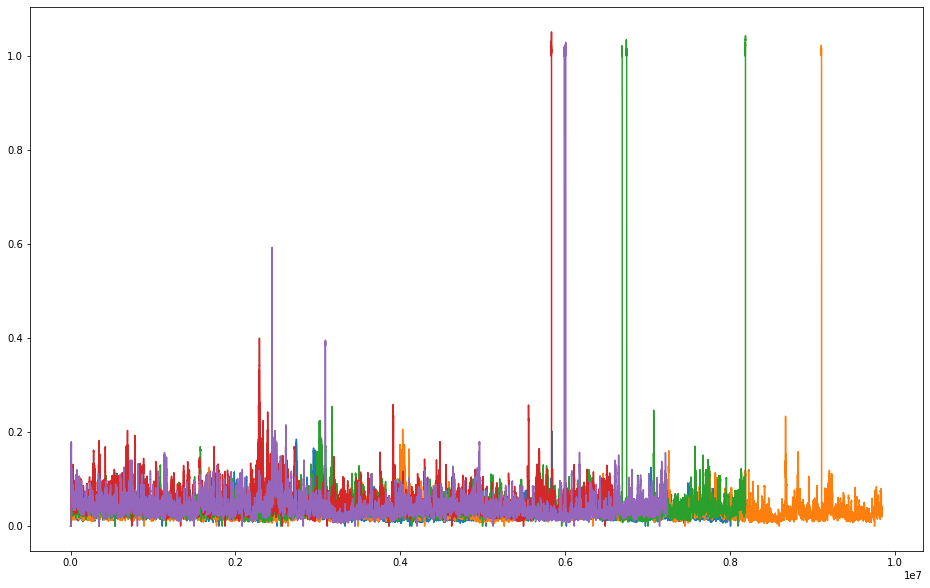

In [87]:
for product in product_list:
    plt.figure(1, figsize=(16, 10))
    plt.plot(all_product_atr[product]);

## Grid Search Optimization

In [88]:
thre_mat

,open,close
0,0.040,-0.0080
1,0.040,-0.0160
2,0.040,-0.0240
3,0.040,-0.0320
4,0.040,-0.0400
...,...,...
95,0.097,-0.0194
96,0.097,-0.0388
97,0.097,-0.0582
98,0.097,-0.0776


In [89]:
result

(0.1931691932452402,
 0.1,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### All Data

In [ ]:
# run from here

In [92]:
%%time
signal_name = "nr.4096"
all_trade_stat = dict([])
for product in product_list:
    all_dates = list(map(lambda x: x, sorted(os.listdir(DATA_PATH + product))))
    n_days = len(all_dates)
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, 
                                HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=0.02)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat)
    all_trade_stat[product] = trade_stat

# Wall time: 24min 46s


CPU times: user 441 ms, sys: 504 ms, total: 945 ms
Wall time: 7min 44s


In [98]:
all_trade_stat['600519'].keys()

odict_keys(['final.result', 'daily.pnl', 'date'])

In [112]:
for key, val in all_trade_stat.items():
    # two level dictionary
    # final.result --->  dataframe
    # daily.pnl ---> array, 2D
    # date ---> array, 1D
    print(key)
    print(val.keys())
    #print(val)

600519
odict_keys(['final.result', 'daily.pnl', 'date'])
000858
odict_keys(['final.result', 'daily.pnl', 'date'])
000568
odict_keys(['final.result', 'daily.pnl', 'date'])
600809
odict_keys(['final.result', 'daily.pnl', 'date'])
002304
odict_keys(['final.result', 'daily.pnl', 'date'])


In [113]:
save(all_trade_stat, OUTPUT_PATH+"/"+"wine_trade_stat_nr_4096_pos_002.pkl")

- it seems the signal value leans to negative

- for example we care about the average pnl

In [114]:
all_trade_stat = load(OUTPUT_PATH+"/"+"wine_trade_stat_nr_4096_pos_002.pkl")

#### Repeat results from deck

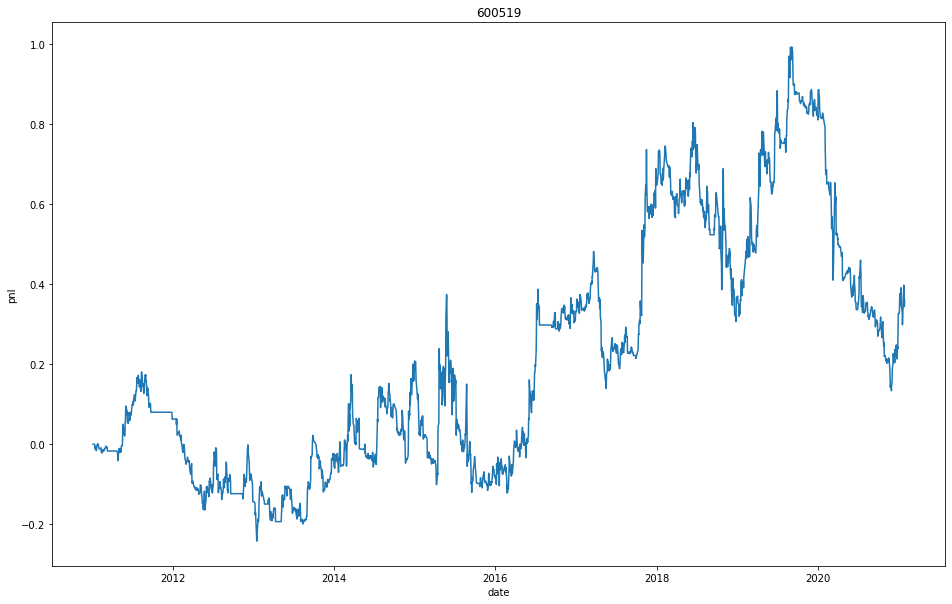

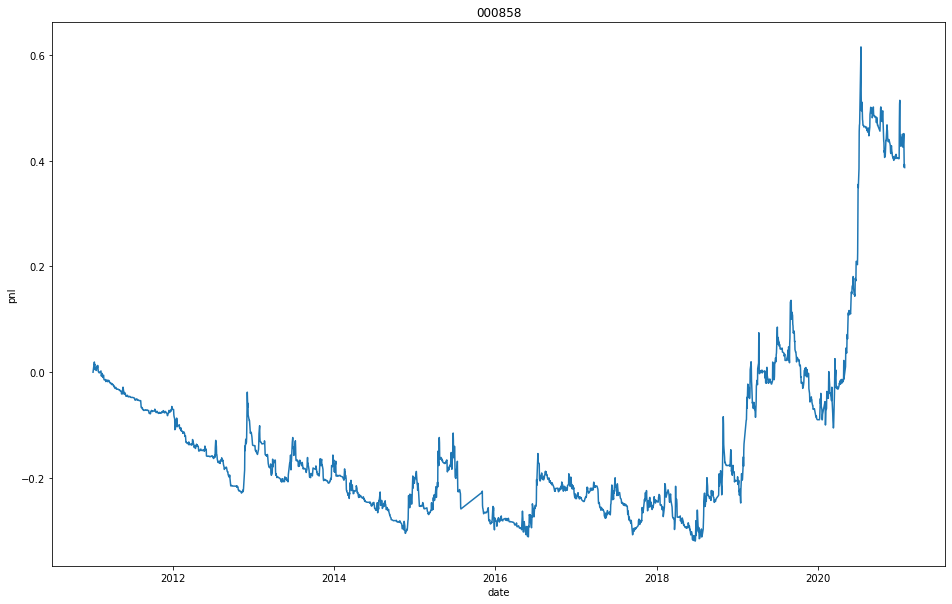

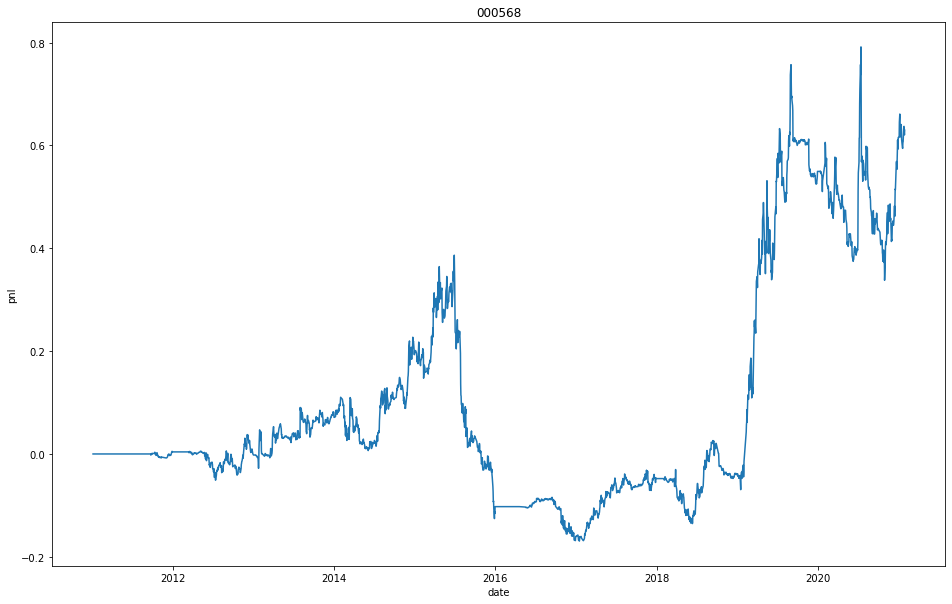

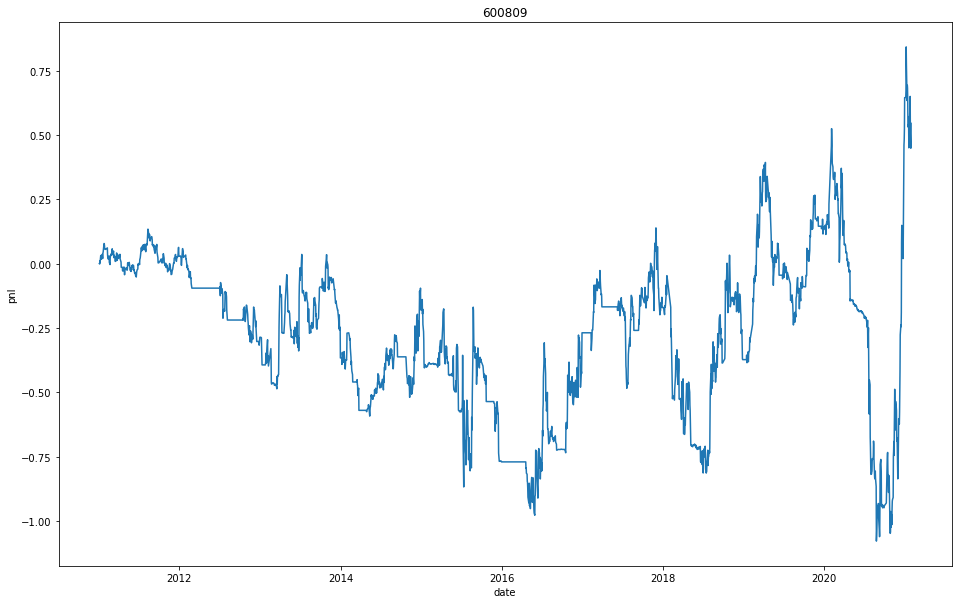

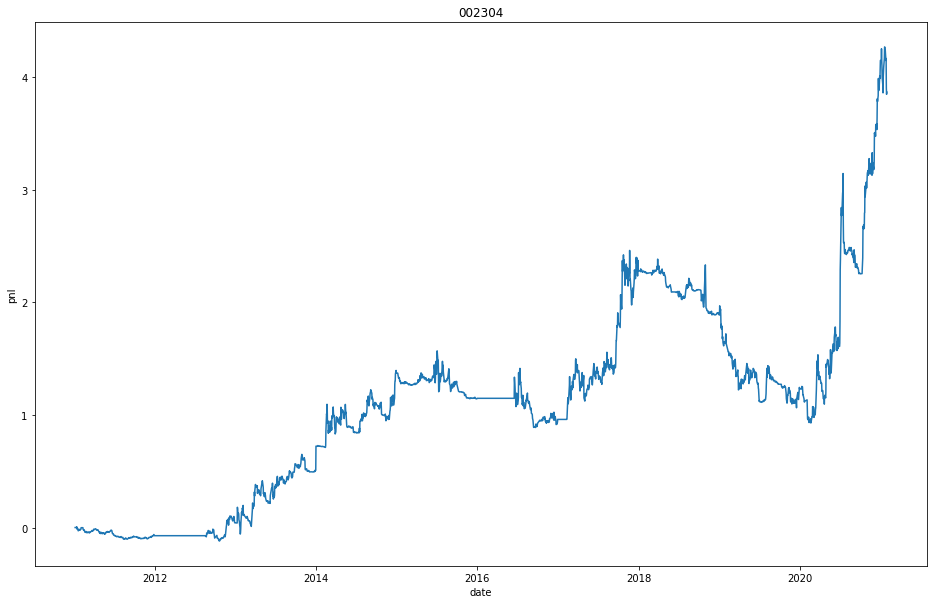

In [115]:
i = 0
for product in product_list:
    trade_stat = all_trade_stat[product]
    good_strat = trade_stat["final.result"]["avg.ret"]>0.001
    good_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    format_dates = np.array([pd.to_datetime(d) for d in trade_stat["date"]])
    i = i+1
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates, good_pnl.cumsum());

- get training samples

- now let's see the in-sample and out-of-sample performance


- the previous result used the whole data set 
- so it may be more optimistic than reality
- now we split the data into training sample and test sample


- at first let's remain 2018 as out-of-sample

- number of training samples

## Another test

### Train Data

In [116]:
%%time
signal_name = "nr.4096"
train_trade_stat = dict([])
for product in product_list:
    all_dates = np.array(list(map(lambda x: x, sorted(os.listdir(DATA_PATH + product)))))
    train_sample = all_dates<"2017"
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, 
                                HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=0.02)
        # all_dates[train_sample] --> keep only 2011, 2012, 2013, 2014, 2015, 2016
        result = compute([delayed(f_par)(file) for file in all_dates[train_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat)
    train_trade_stat[product] = trade_stat
    
# Wall time: 14min 54s


CPU times: user 291 ms, sys: 376 ms, total: 667 ms
Wall time: 4min 10s


In [117]:
save(train_trade_stat, OUTPUT_PATH+"/wine_train_trade_stat.pkl")

### Test Data Train Data (In-sample test)

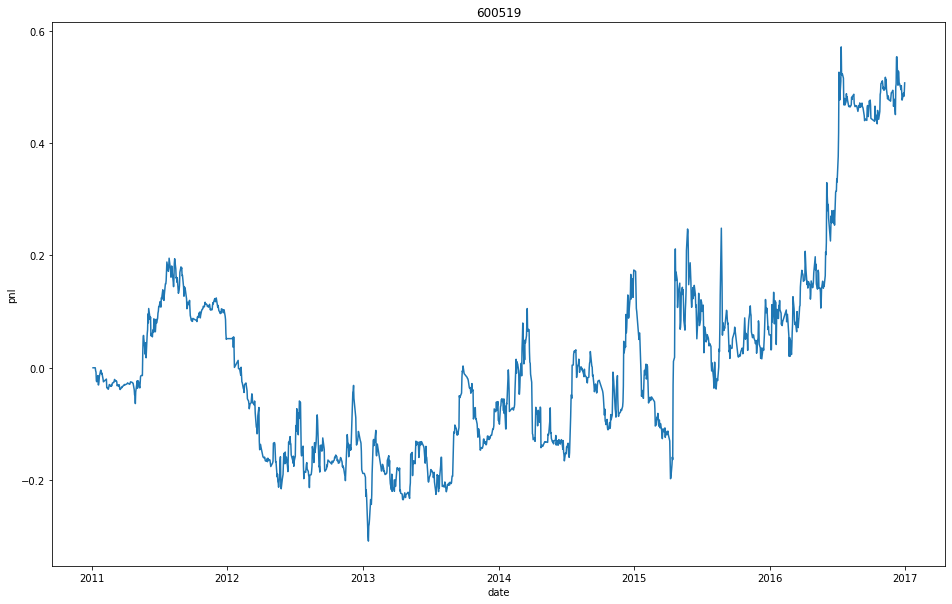

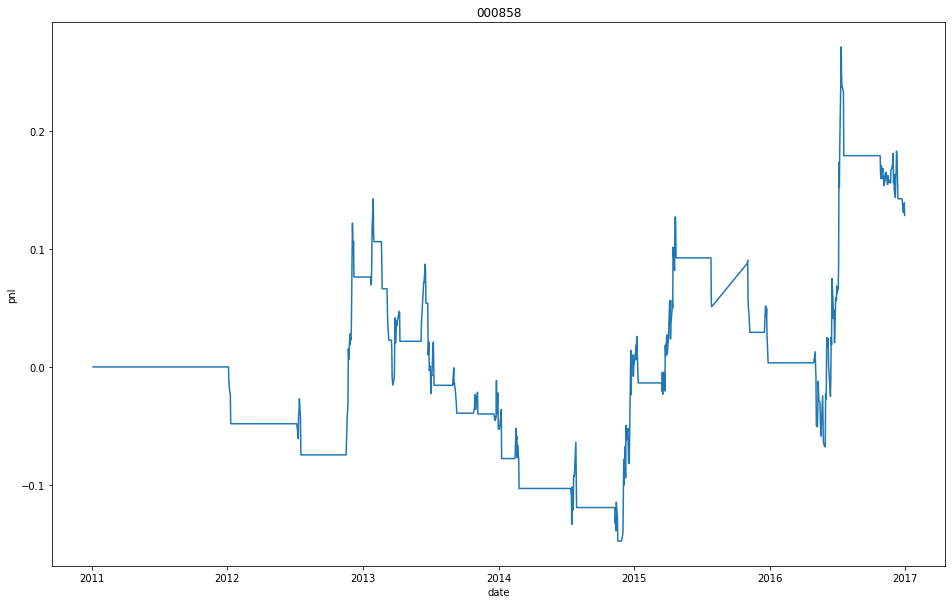

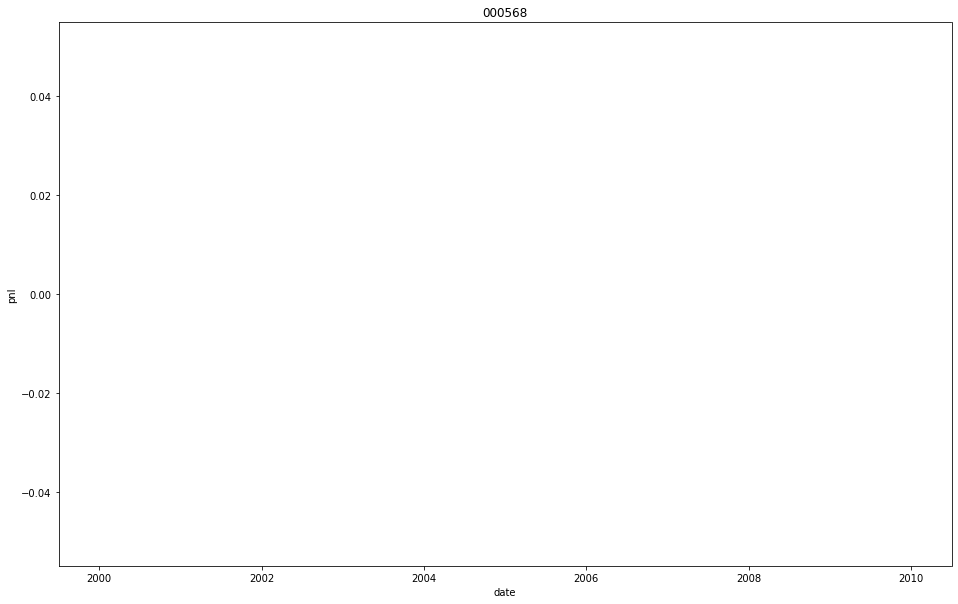

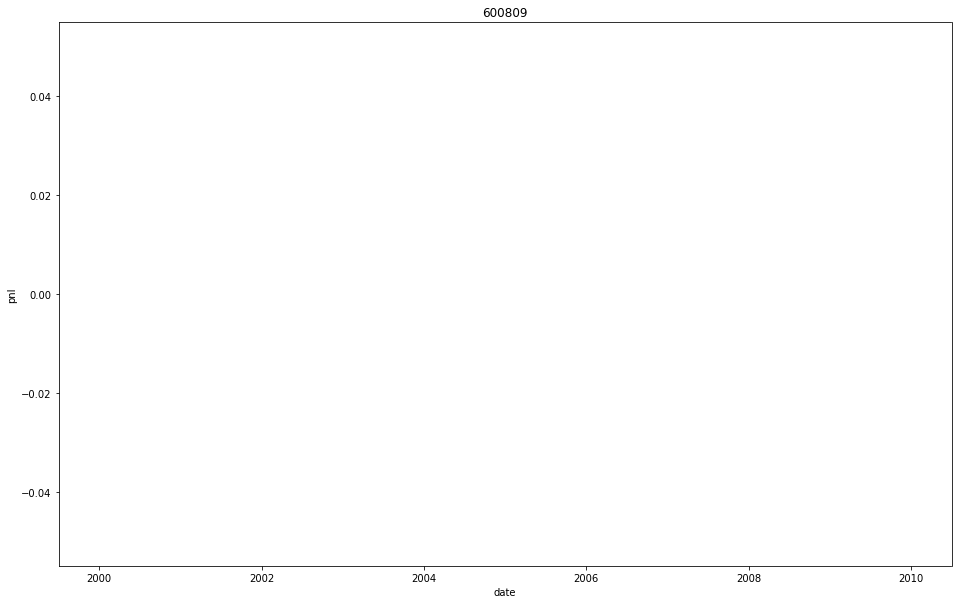

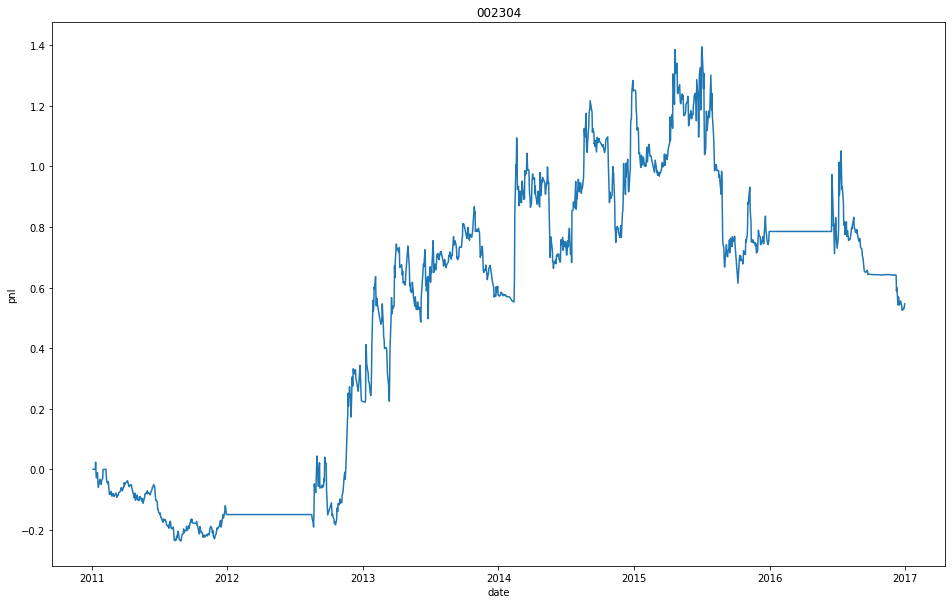

In [127]:
i = 0
all_trade_stat = load(OUTPUT_PATH+"/wine_train_trade_stat.pkl")
for product in product_list:
    trade_stat = all_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.ret"]>0.001) & (trade_stat["final.result"]["num"]>20)
    good_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    i = i+1
    all_dates = np.array(list(map(lambda x: x, sorted(os.listdir(DATA_PATH + product)))))
    format_dates = np.array([pd.to_datetime(d) for d in trade_stat["date"]])
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates, good_pnl.cumsum());


#### Test data > 2017

In [128]:
%%time
signal_name = "nr.4096"
test_trade_stat = dict([])
for product in product_list:
    test_sample = all_dates>"2017"
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH, atr_filter=0.02)
        result = compute([delayed(f_par)(file) for file in all_dates[test_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat)
    test_trade_stat[product] = trade_stat

## Wall time: 18min 54s

CPU times: user 257 ms, sys: 374 ms, total: 632 ms
Wall time: 4min 56s


In [129]:
save(test_trade_stat, OUTPUT_PATH+"/wine_test_trade_stat.pkl")

- now we get the out-of-sample test result

In [130]:
train_trade_stat= load(OUTPUT_PATH+"/wine_train_trade_stat.pkl")
test_trade_stat= load(OUTPUT_PATH+"/wine_test_trade_stat.pkl")

600519 train sharpe  0.27935434991583 test sharpe  -0.3176023795371997
000858 train sharpe  0.20731596624276705 test sharpe  -0.025527919859114432
000568 train sharpe  0.12833136343003676 test sharpe  0.5863385391152066
600809 train sharpe  nan test sharpe  nan
002304 train sharpe  0.22560104053921687 test sharpe  0.8243414253748972


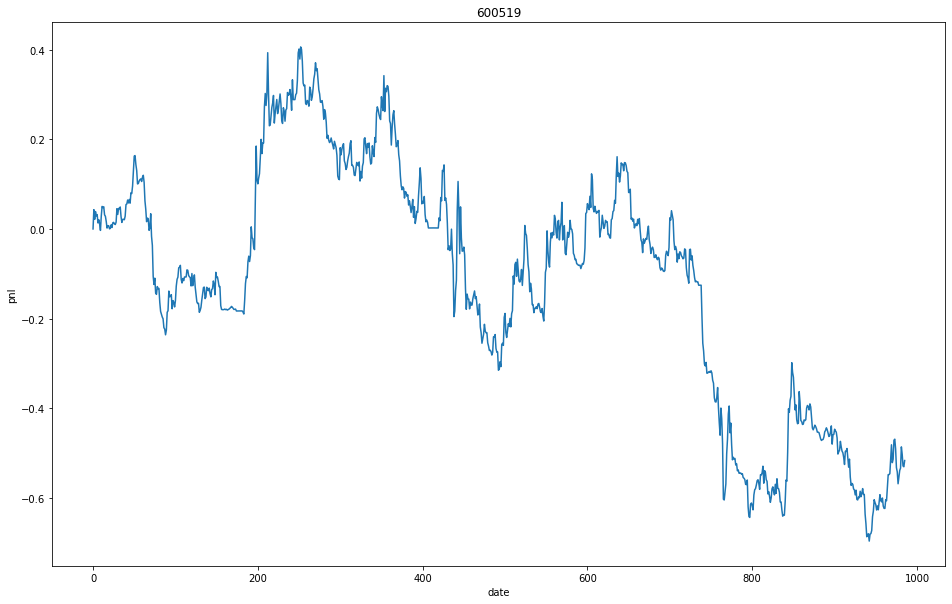

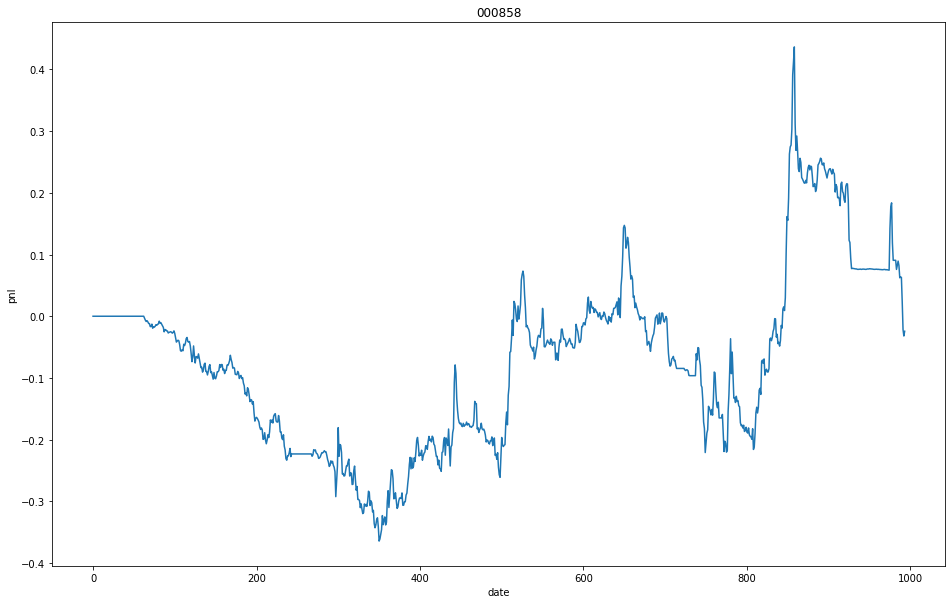

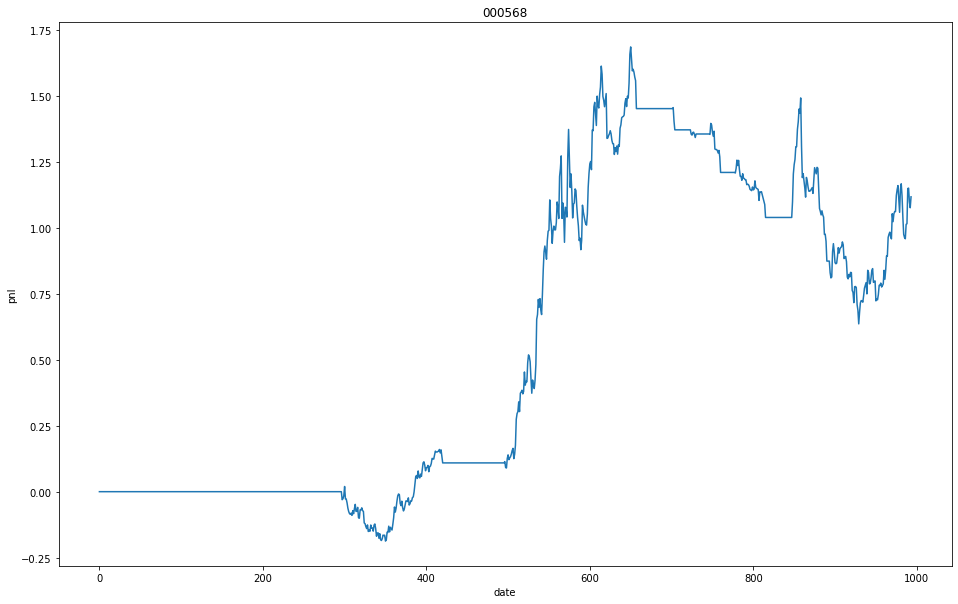

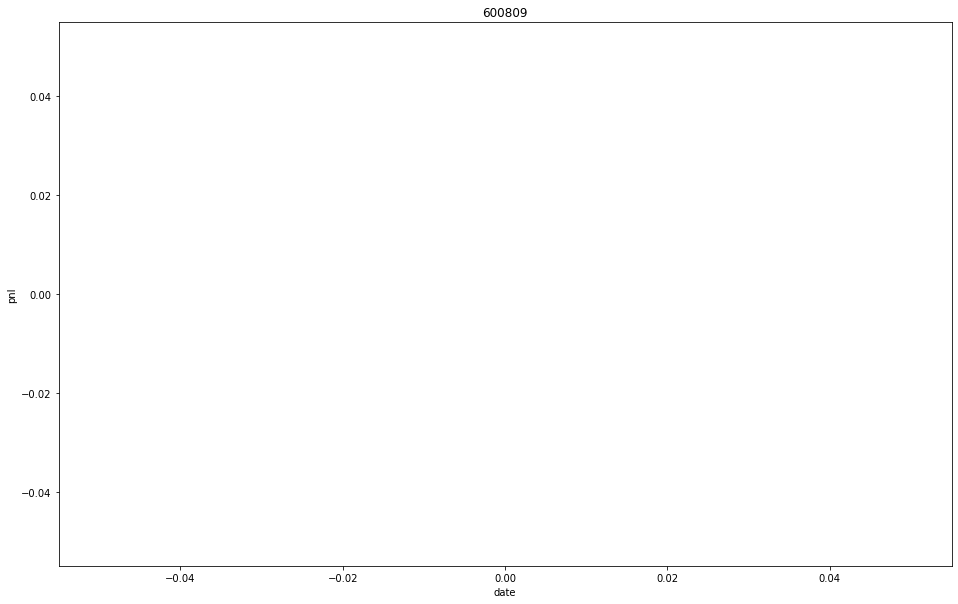

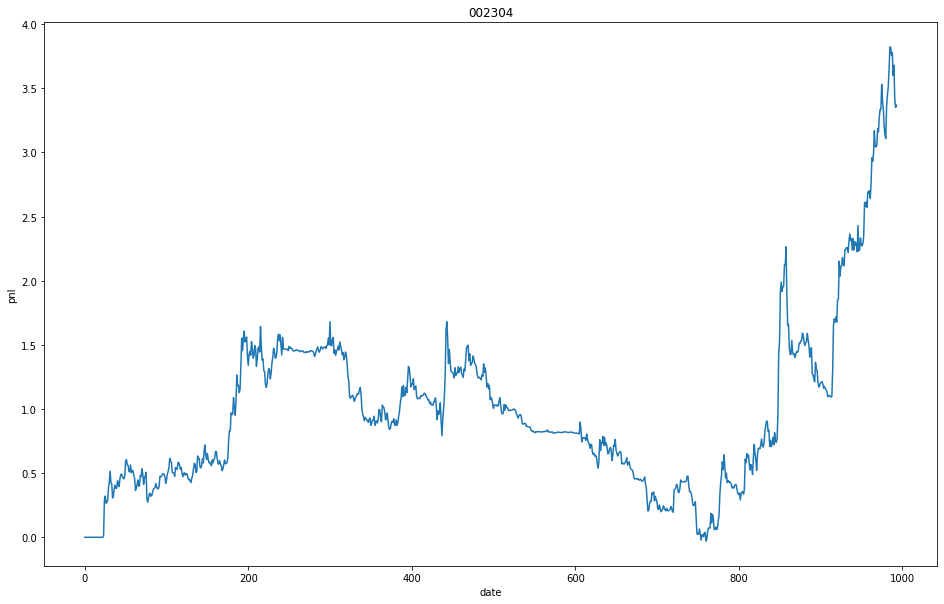

In [131]:
i = 0
for product in product_list:
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.ret"]>0.001) & (trade_stat["final.result"]["num"]>10)
    train_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    trade_stat = test_trade_stat[product]
    test_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    i = i+1
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(test_pnl.cumsum());

# 600519 train sharpe  0.27935434991583 test sharpe  -0.3176023795371997
# 000858 train sharpe  0.20731596624276705 test sharpe  -0.025527919859114432
# 000568 train sharpe  0.12833136343003676 test sharpe  0.5863385391152066
# 600809 train sharpe  nan test sharpe  nan
# 002304 train sharpe  0.22560104053921687 test sharpe  0.8243414253748972







- now calculate the result of test samples

- Homework:
- you can try using total.trade.imb.4096 to test again
- you can try using 1024/2048 to repeat this process and compare the result
- you can change the atr threshold of 20 to other values
- you can change the split of train/test samples
- you can try using reverse=1 and -1